# Assessing task performance

In order for the machine to learn, there will be some objectively quantifiable measure of performance. The machine must know what the word "improve" means. For instance, most college professors assess the performance of their students by giving them exams. These exams are usually given a grade out of 100 points, where a higher grade translates to better exam (task) performance.

## Assessing regression task performance

There are numerous performance metrics that have been devised for both regression and classification tasks. Typically, with regression tasks, we are interested in getting as close to the target variable as possible. The difference between the prediction made by the machine learning model and the ground truth is called the **error** or **residual**.  For this rest of this chapter, we will focus on assessing task performance. Let's begin by reading in our housing data.

In [1]:
import pandas as pd
housing = pd.read_csv('../data/housing_sample.csv')
housing.head()

,Neighborhood,Exterior1st,YearBuilt,LotFrontage,GrLivArea,GarageArea,BedroomAbvGr,FullBath,OverallQual,HeatingQC,SalePrice
0,CollgCr,VinylSd,2003,65.0,1710,548,3,2,7,Ex,208500
1,Veenker,MetalSd,1976,80.0,1262,460,3,2,6,Ex,181500
2,CollgCr,VinylSd,2001,68.0,1786,608,3,2,7,Ex,223500
3,Crawfor,Wd Sdng,1915,60.0,1717,642,3,1,7,Gd,140000
4,NoRidge,VinylSd,2000,84.0,2198,836,4,2,8,Ex,250000


### Previous models

Let's recreate our simple models that we built previously.

In [2]:
mean_price = housing['SalePrice'].mean()
price_per_sq_foot = (housing['SalePrice'] / housing['GrLivArea']).mean()
group_price = [housing.query('GrLivArea < 1500')['SalePrice'].mean(),
               housing.query('1500 <= GrLivArea <= 2000')['SalePrice'].mean(),
               housing.query('GrLivArea > 2000')['SalePrice'].mean()]

def model_1_simple_avg(sq_foot):
    return round(mean_price, -3)

def model_2_avg_ppsf(sq_foot):
    return round(price_per_sq_foot * sq_foot, -3)

def model_3_bin_avg(sq_foot):
    cat = 0 if sq_foot < 1500 else 1 if sq_foot <= 2000 else 2
    return group_price[cat]

### Function to make prediction

To automate the process of predicting, let's create a function that accepts the model and data as inputs and outputs the predicted values. We return the values as a numpy array.

In [3]:
import numpy as np
def make_prediction(model, X):
    return np.array([model(x) for x in X])

Let's create a list of house square footages we would like to use to make a prediction.

In [4]:
X = [1200, 1800, 2750]

Let's pass one of our models along with this data to the `make_prediction` function to return the predicted sale prices. Here, we use the second model that uses average price per square foot.

In [5]:
make_prediction(model_2_avg_ppsf, X)

array([145000., 217000., 332000.])

### Make predictions on labeled data

If we want to test how well our model is performing, we need to make predictions on data where the sale price is known. Let's use our existing housing data and make a prediction for each home. The first five predicted values are shown.

In [6]:
X = housing['GrLivArea']
y_pred = make_prediction(model_2_avg_ppsf, X)
y_pred[:5]

array([206000., 152000., 215000., 207000., 265000.])

Since this data is labeled, we can output the ground truth to see how close our predictions were to the actual values.

In [7]:
y = housing['SalePrice']
y[:5]

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

### Plot the predictions and actual values

It can be instructive to plot the actual outcome and the value predicted by the model on the same plot with a line connecting the two points denoting the error. The following function plots 20 random points (by default) along with their predicted value and error given one of the above models.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pred_vs_actual(model, n=20):
    housing_sample = housing.sample(n, random_state=123)
    X = housing_sample['GrLivArea']
    y = housing_sample['SalePrice']
    y_pred = make_prediction(model, X)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(X, y, marker='o', label='Ground Truth')
    ax.scatter(X, y_pred, label='Prediction')
    ax.vlines(X, y, y_pred, linestyle='--', label='error')
    
    ax.set_title(f"Random {n} points from {model.__name__}")
    ax.set_xlabel('Square Feet')
    ax.set_ylabel('Sale Price')
    ax.legend()

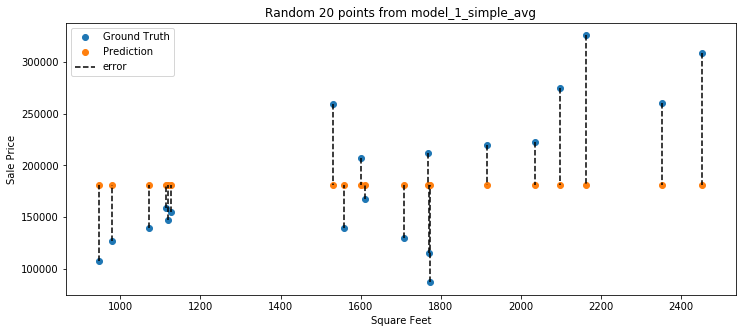

In [9]:
plot_pred_vs_actual(model_1_simple_avg)

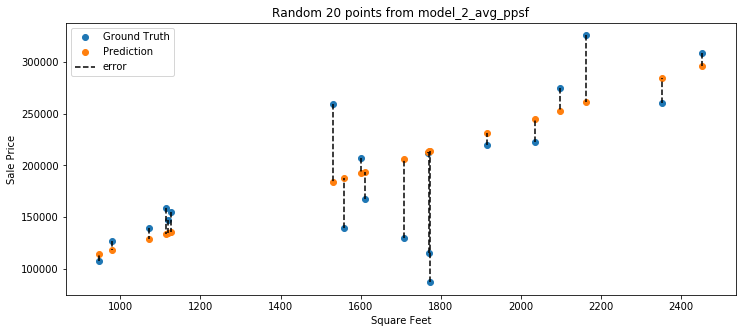

In [10]:
plot_pred_vs_actual(model_2_avg_ppsf)

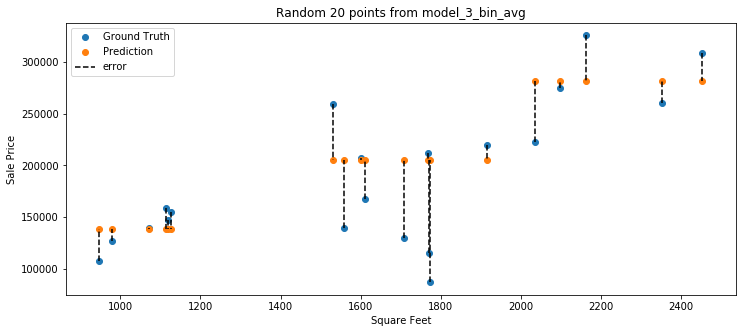

In [11]:
plot_pred_vs_actual(model_3_bin_avg)

## Comparing model performance

Once we have our models, we can determine which one has the best performance. There are several metrics we can use to compare the models against one another. Here are some example metrics that we could report for each model:

* Calculate the absolute value of all the errors and sum them
* Calculate the single largest absolute error
* Square all the errors and then sum these squared values
* Cube all the errors, and then sum the absolute value of all these cubed values
* Take the log of all the absolute value of errors and sum all these logged values

For all of these metrics, the model with the lowest value would be classified as the best. There is no limit to the number of error metrics that can be devised. As long as they produce a single statistic that we can use to rank the performance of each model, then it is a valid metric.

### Sum of squared error

The most common approach is to use the squared error. Adding all of the squared errors together yields what is known as the **sum of squared error** and is often abbreviated as SSE. Let's calculate the SSE of the second model on the first five values. We first calculate the actual (raw) error.

In [12]:
X = housing['GrLivArea']
y = housing['SalePrice']
y_pred = make_prediction(model_2_avg_ppsf, X)
error = y[:5] - y_pred[:5]
error

0     2500.0
1    29500.0
2     8500.0
3   -67000.0
4   -15000.0
Name: SalePrice, dtype: float64

Once we find the raw error, we square each term, making each value positive (and very large).

In [13]:
squared_error = error ** 2
squared_error

0    6.250000e+06
1    8.702500e+08
2    7.225000e+07
3    4.489000e+09
4    2.250000e+08
Name: SalePrice, dtype: float64

Summing these squared errors gives us our error metric.

In [14]:
sum_squared_error = squared_error.sum()
sum_squared_error

5662750000.0

### Comparing models

Having this one metric to objectively quantify our models makes for easy comparison. Let's write a function that computes the SSE on all the data for any model. It accepts the input and output data along with the model. In the function, the predicted values are calculated. From here, the raw error is found, then squared, summed and returned as our metric.

In [15]:
def sse(X, y, model):
    y_pred = make_prediction(model, X)
    error = y - y_pred
    squared_error = error ** 2
    return squared_error.sum()

Let's use this function to calculate the SSE for all three of the models. We return a pandas Series mapping the name of the function (using the special attribute `__name__`) to the error.

In [16]:
X = housing['GrLivArea']
y = housing['SalePrice']
models = [model_1_simple_avg, model_2_avg_ppsf, model_3_bin_avg]
model_sse = pd.Series({model.__name__: sse(X, y, model) for model in models})
model_sse

model_1_simple_avg    9.207920e+12
model_2_avg_ppsf      4.662359e+12
model_3_bin_avg       5.393935e+12
dtype: float64

These large numbers are actually quite difficult to compare by inspection. Let's use a bar plot to make the comparisons easier. Models two and three appear to be substantially better than model one.

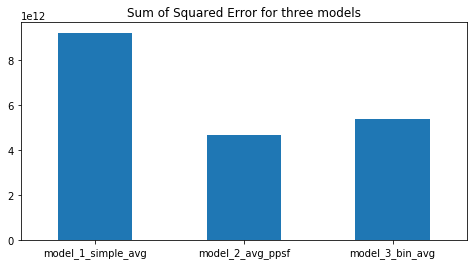

In [17]:
model_sse.plot(kind='bar', figsize=(8, 4), title='Sum of Squared Error for three models', rot=0);

### Root mean squared error

One issue with the sum of squared error is that it is difficult to interpret. The number tends to be quite large and can increase with more data. As we saw above, it wasn't until we plotted the SSE that we could tell the differences between the models.

The root mean squared error (RMSE) is a different but very similar error metric that we can use as our objective measure of performance. The calculation for RMSE begins like SSE by calculating the raw error and squaring it. But, instead of taking the sum, we take the mean. By calculating the mean instead of the sum, we get a **relative** measure of performance instead of **absolute**. In this instance, relative indicates a per-house average squared error. The square root of this mean is taken to produce the RMSE. Let's create a function to calculate the RMSE.

In [18]:
def rmse(X, y, model):
    y_pred = make_prediction(model, X)
    error = y - y_pred
    squared_error = error ** 2
    mse = squared_error.mean()
    return np.sqrt(mse)

The RMSE is now calculated for each model on all of the data.

In [19]:
model_rmse = pd.Series({model.__name__: rmse(X, y, model) for model in models})
model_rmse

model_1_simple_avg    79415.330985
model_2_avg_ppsf      56510.145963
model_3_bin_avg       60782.203726
dtype: float64

These relative values are much easier to compare by inspection than the SSE. Still, it is helpful to visualize this new performance metric.

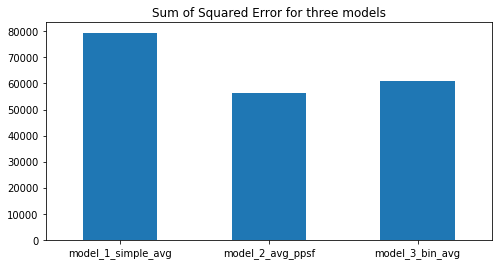

In [20]:
model_rmse.plot(kind='bar', figsize=(8, 4), title='Sum of Squared Error for three models', rot=0);

### Help remembering calculations

The names sum of squared error and root mean squared error are descriptive and should help you remember how the metric is derived. The descriptions give you the order of calculations from right to left. For instance, the RMSE first takes the **E**rror, then **S**quares it, computes the **M**ean, and finally takes the square **R**oot.

### SSE and RSME always rank models the same

Although the SSE and RMSE error metrics produce different values, they always rank the models in the exact same order. For instance, if we built ten different models and calculated the ranking based on SSE, it would be the exact same as the ranking based on RMSE. Mathematically, the RMSE can be derived directly from the SSE by dividing it by the total number of points and then taking the square root. Let's verify this below.

In [ ]:
rmse(X, y, model_2_avg_ppsf)

In [ ]:
np.sqrt(sse(X, y, model_2_avg_ppsf) / len(X))

### Is the RMSE just the mean absolute error?

The mean absolute error (MAE) is simply the average of the absolute value of all the errors. The RMSE calculation produces a number that appears to be the MAE. This units of both of these error metrics are the original units of the target variable (dollars). The RMSE is NOT the MAE, though the two values will often be similar. Let's prove this with a simple example involving an array containing three errors, 10, 20, and 30.

In [ ]:
errors = np.array([10, 20, 30])

Here, we calculate the MAE. It's unnecessary to include the `abs` function, but is presented here to match the exact definition of the MAE.

In [ ]:
np.abs(errors).mean()

The RMSE produces a slightly higher result.

In [ ]:
np.sqrt((errors ** 2).mean())

### Generic function for any error metric

Below, we create a function that generalizes our procedure from above. You supply it the data, models, and the error metric function. It calculates a prediction and error for each input data for each model and then plots the single error metric for each model. It uses the name of the function as the title in the plot.

In [ ]:
def plot_error(X, y, models, error_func):
    errors = pd.Series({model.__name__: error_func(X, y, model) for model in models})
    errors.plot(kind='bar', figsize=(8, 4), title=error_func.__name__, rot=0)

Let's try this out with our two error metrics.

In [ ]:
plot_error(X, y, models, rmse)

In [ ]:
plot_error(X, y, models, sse)

### Determining the best model
From the plots above, it's clear that model 2 outperforms the others based on both error metrics. If our machine learning toolset were limited to just these models, we would choose model 2 as our final model and use it to make future predictions when new houses come on the market.

### More complex models to come

All of these models were built from scratch with a few lines of code. They were devised so that you could clearly see how a model was built, predictions made, and errors calculated. We will now move on to use more powerful and complex models. Instead of building them by hand will rely on the scikit-learn library.

## Exercises

### Exercise 1

<span  style="color:green; font-size:16px">Create functions that calculate task performance for each of the following error metrics:</span>


<span  style="color:green; font-size:16px">
    
* Mean Absolute Error (MAE) - find the absolute error of each prediction, then return the mean of these values
* Maximum Absolute Error - find the absolute error of each prediction, then return the maximum of these values
* Mean of Cubed Error - find the absolute value of the cubed error of each, then return the mean of these values
* Mean Logged Error - find the absolute error of each prediction, then take the natural logarithm of each, and return the mean of these values.
* Come up with your own error metric

</span>

<span style="color:green; font-size:16px">Use each function individually to get the performance measurement on model 3 from above. Then use the `plot_error` function to plot each error for each model.</span>